In [0]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
!wget --no-check-certificate https://transfer.sh/XnpD8/Flower.zip -O /tmp/Flower.zip


Redirecting output to ‘wget-log’.


In [11]:
os.path.getsize("/tmp/Flower.zip")

429184371

In [9]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import zipfile
local_zip = '/tmp/Flower.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
os.listdir('/tmp')

In [13]:
import shutil
SOURCE = "/tmp/Dataset"
BACKUP = "/content/drive/My Drive/Colab Notebooks/Dataset1"
# create a backup directory
shutil.copytree(SOURCE, BACKUP)
print os.listdir(BACKUP)

['train', 'validation']


In [0]:
os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/")

Now let's download the weights:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


Redirecting output to ‘wget-log’.


In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print 'last layer output shape:', last_layer.output_shape
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now let's stick a fully connected classifier on top of `last_output`:

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

Get our flowers dataset

In [0]:
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# local_zip = '/tmp/Flower.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
base_dir = '/content/drive/My Drive/Colab Notebooks/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


In [0]:
# Directory with our training red roses
train_rose_dir = os.path.join(train_dir, 'HOA HONG DO')

# Directory with our training Xuyen Chi Flowers
train_xuyenchi_dir = os.path.join(train_dir, 'HOA XUYEN CHI')

# Directory with our validation red roses pictures
validation_rose_dir = os.path.join(validation_dir, 'HOA HONG DO')

# Directory with our validation Xhuyen Chi Flowers pictures
validation_xuyenchi_dir = os.path.join(validation_dir, 'HOA XUYEN CHI')


In [12]:
train_rose_fnames = os.listdir(train_rose_dir)
train_xuyenchi_fnames = os.listdir(train_xuyenchi_dir)
print(train_rose_fnames)
print(train_xuyenchi_fnames)

['Copy of IMG_0086.JPG', 'Copy of IMG_0092.JPG', 'Copy of IMG_0082.JPG', 'Copy of IMG_0088.JPG', 'Copy of IMG_0085.JPG', 'Copy of IMG_0091.JPG', 'Copy of IMG_0089.JPG', 'Copy of IMG_0090.JPG', 'Copy of IMG_0073.JPG', 'Copy of IMG_0075.JPG', 'Copy of IMG_0078.JPG', 'Copy of IMG_0081.JPG', 'Copy of IMG_0074.JPG', 'Copy of IMG_0072.JPG', 'Copy of IMG_0077.JPG', 'Copy of IMG_0076.JPG', 'Copy of IMG_0080.JPG', 'Copy of IMG_0079.JPG', 'Copy of IMG_0069.JPG', 'Copy of IMG_0070.JPG', 'Copy of IMG_0067.JPG', 'Copy of IMG_0066.JPG', 'Copy of IMG_0071.JPG', 'Copy of IMG_0068.JPG', 'Copy of IMG_0052.JPG', 'Copy of IMG_0059.JPG', 'Copy of IMG_0057.JPG', 'Copy of IMG_0054.JPG', 'Copy of IMG_0056.JPG', 'Copy of IMG_0061.JPG', 'Copy of IMG_0058.JPG', 'Copy of IMG_0053.JPG', 'Copy of IMG_0044.JPG', 'Copy of IMG_0049.JPG', 'Copy of IMG_0046.JPG', 'Copy of IMG_0043.JPG', 'Copy of IMG_0050.JPG', 'Copy of IMG_0042.JPG', 'Copy of IMG_0045.JPG', 'Copy of IMG_0048.JPG', 'Copy of IMG_0047.JPG', 'Copy of IMG_00

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        # class_mode='binary'
        class_mode = 'categorical'
        )
    

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        #class_mode='binary'
        class_mode = 'categorical'
        )

Found 272 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Finally, let's train the model using the features we extracted. We'll train on all 272 images available, for 2 epochs, and validate on all 30 test images.

In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
 - 382s - loss: 0.1074 - acc: 0.9620 - val_loss: 0.1906 - val_acc: 0.9040
Epoch 2/2
 - 339s - loss: 0.0644 - acc: 0.9750 - val_loss: 0.7317 - val_acc: 0.7280


You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 test images. (This may take 15-20 minutes to run.)

In [17]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
 - 379s - loss: 0.0323 - acc: 0.9873 - val_loss: 0.4806 - val_acc: 0.8400
Epoch 2/10
 - 339s - loss: 0.0252 - acc: 0.9925 - val_loss: 0.4580 - val_acc: 0.8680
Epoch 3/10
 - 338s - loss: 0.0296 - acc: 0.9865 - val_loss: 0.4128 - val_acc: 0.8960
Epoch 4/10
 - 340s - loss: 0.0205 - acc: 0.9918 - val_loss: 0.4302 - val_acc: 0.9000
Epoch 5/10
 - 341s - loss: 0.0176 - acc: 0.9952 - val_loss: 0.4159 - val_acc: 0.8960
Epoch 6/10
 - 343s - loss: 0.0308 - acc: 0.9908 - val_loss: 0.3936 - val_acc: 0.8960
Epoch 7/10
 - 369s - loss: 0.0304 - acc: 0.9875 - val_loss: 0.3989 - val_acc: 0.9000
Epoch 8/10
 - 343s - loss: 0.0262 - acc: 0.9935 - val_loss: 0.4198 - val_acc: 0.8960
Epoch 9/10
 - 340s - loss: 0.0317 - acc: 0.9905 - val_loss: 0.3841 - val_acc: 0.9040
Epoch 10/10
 - 337s - loss: 0.0148 - acc: 0.9945 - val_loss: 0.3812 - val_acc: 0.9000


We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

Text(0.5,1,u'Training and validation loss')

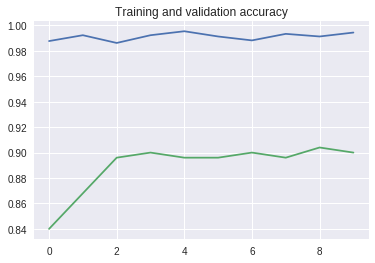

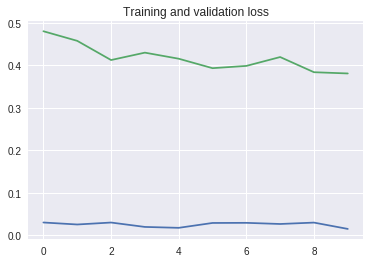

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [0]:
model.save("./colab_model.h5")


In [42]:
from PIL import Image
import numpy as np

list_of_labels = os.listdir(train_dir)
list_of_labels = sorted(list_of_labels)

# pick a file in HOA HONG DO
rose_file_names = os.listdir("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA HONG DO/")

img = Image.open("/content/drive/My Drive/Colab Notebooks/Dataset/validation/HOA HONG DO/" + rose_file_names[4])
img_resize = img.resize((150,150))
np_image = np.array(img_resize)
np_image = np_image.reshape(1,150,150,3) * 1./255

id_predict = np.argmax(model.predict(np_image))
prediction = list_of_labels[id_predict]
print("Computer thinks this is a: {}".format(prediction))

Computer thinks this is a: HOA HONG DO


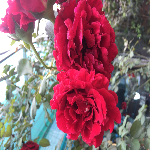

In [32]:
img_resize

In [0]:
# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = validation_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")

In [0]:
# Make this more efficient. Let's rename the file to the name of prediction
for label in list_of_labels:
    folder_path = train_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        img = Image.open(file_path)
        img_resize = img.resize((150,150))
        np_image = np.array(img_resize)
        np_image = np_image.reshape(1,150,150,3) * 1./255
        id_predict = np.argmax(model.predict(np_image))
        confidence = int(round(np.max(model.predict(np_image)) * 100))
        prediction = list_of_labels[id_predict]
        os.rename(file_path,folder_path + "/" + str(index) + "_" + prediction + "_" + str(confidence) + ".JPG")

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.

In [22]:
# from google.colab import files
# files.download("./colab_model.h5")

KeyboardInterrupt: ignored

In [0]:
list_of_labels = os.listdir(train_dir)
list_of_labels = sorted(list_of_labels)
# Reset images' names
for label in list_of_labels:
    folder_path = validation_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        os.rename(file_path,folder_path + "/Image_" + str(index) + ".JPG")
          
# Reset images' names
for label in list_of_labels:
    folder_path = train_dir + "/" + label
    list_of_files = os.listdir(folder_path)
    for index, file in enumerate(list_of_files):
        file_path = folder_path + "/" + file
        os.rename(file_path,folder_path + "/Image_" + str(index) + ".JPG")